# V_SLOPE projection

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from shapely.geometry import mapping
from shapely.geometry import box
from rasterio.mask import mask
import matplotlib as mpl
from matplotlib.colors import LogNorm, SymLogNorm
import os

import warnings
warnings.filterwarnings("ignore")

In [2]:
def tiff2arr(tif_fid, mask=None):
    if mask is not None:
        with rasterio.open(tif_fid) as src:
            feature = [mapping(mask)]
            masked_band = mask(src, feature, crop=True, all_touched=True)
            arr = masked_band[0]
            pixel_georeferences = masked_band[1] 
            return arr, pixel_georeferences

    else: 
        with rasterio.open(tif_fid) as src:
            arr = src.read(1)
            return arr

In [3]:
E = tiff2arr("./data/010D_11455_131313.geo.E.tif")
N = tiff2arr("./data/010D_11455_131313.geo.N.tif")
UP = tiff2arr("./data/010D_11455_131313.geo.U.tif")

x, y = 1200, 1200
print((N[1500, 1500], E[1500, 1500], UP[1500, 1500]))

(-0.15797113, 0.6159272, 0.77180225)


In [4]:
LOS_dir = abs(np.rad2deg(np.arctan(N[E!=0]/E[E!=0])))+90
incidence_angle = np.rad2deg(np.arccos(UP[UP!=0]))
Flight_dir = LOS_dir+90
mean_flight_dir = np.mean(Flight_dir)
mean_incidence_angle = np.mean(incidence_angle)

#LOS compoments with mean_flight_dir, mean_incidence_angle
D_N = np.sin(np.deg2rad(mean_incidence_angle))*np.sin(np.deg2rad(180 - mean_flight_dir))
D_E = np.sin(np.deg2rad(mean_incidence_angle))*np.sin(np.deg2rad(270 - mean_flight_dir))
D_U = np.cos(np.deg2rad(mean_incidence_angle))

print((mean_flight_dir, mean_incidence_angle))
print((D_N, D_E, D_U))

(194.31448, 38.55269)
(-0.15409085025268343, 0.6038846499841909, 0.78203535)


## Toy gausian hill

In [5]:
def gaussian_hill_elevation(n, b = 2.5):
    x, y = np.meshgrid(np.linspace(-b,b,n),
    np.linspace(-b,b,n))

    z = np.exp(-x*x-y*y)
    return (x, y, z)

n = 211
x, y, z = gaussian_hill_elevation(n, b=2.5)
z=z*100

dx,dy = np.gradient(z)
slope_DEM = np.rad2deg(np.arctan(np.sqrt((dx**2) + (dy**2))))
aspect_DEM = np.rad2deg(np.arctan2(dy, -dx))+180

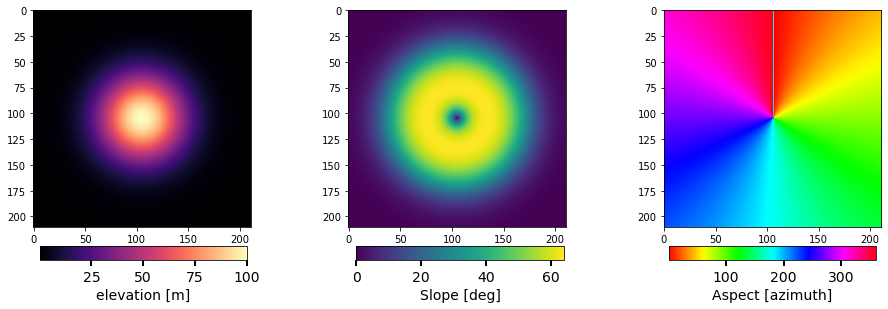

In [6]:
fig, ax = plt.subplots(1,3, figsize=(16,4))
im = ax[0].imshow(z, cmap="magma")
cax = fig.add_axes([0.15, 0.01, 0.18, 0.05])
cmap = mpl.cm.magma
norm = mpl.colors.Normalize(vmin=np.min(z), vmax=np.max(z))
cbar = mpl.colorbar.ColorbarBase(ax=cax, cmap=cmap, norm=norm, orientation='horizontal')
cbar.set_label('elevation [m]', size=14)
cbar.ax.tick_params(labelsize=14, width=2, length=6) 

im = ax[1].imshow(slope_DEM, cmap="viridis")
cax = fig.add_axes([0.425, 0.01, 0.18, 0.05])
cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=np.min(slope_DEM), vmax=np.max(slope_DEM))
cbar = mpl.colorbar.ColorbarBase(ax=cax, cmap=cmap, norm=norm, orientation='horizontal')
cbar.set_label('Slope [deg]', size=14)
cbar.ax.tick_params(labelsize=14, width=2, length=6) 

im = ax[2].imshow(aspect_DEM, cmap="hsv")
cax = fig.add_axes([0.696, 0.01, 0.18, 0.05])
cmap = mpl.cm.hsv
norm = mpl.colors.Normalize(vmin=np.min(aspect_DEM), vmax=np.max(aspect_DEM))
cbar = mpl.colorbar.ColorbarBase(ax=cax, cmap=cmap, norm=norm, orientation='horizontal')
cbar.set_label('Aspect [azimuth]', size=14)
cbar.ax.tick_params(labelsize=14, width=2, length=6) 

## Slope components and calculate C

In [7]:
slope_N = np.cos(np.deg2rad(slope_DEM))*np.sin(np.deg2rad(aspect_DEM-90))
slope_E = -1*np.cos(np.deg2rad(slope_DEM))*np.cos(np.deg2rad(aspect_DEM-90))
slope_U = np.sin(np.deg2rad(slope_DEM))

#How I calculated these
# slope_N2 = np.cos(np.deg2rad(aspect_DEM))*np.cos(np.deg2rad(slope_DEM))
# slope_E2 = np.sin(np.deg2rad(aspect_DEM))*np.cos(np.deg2rad(slope_DEM))
# slope_U2 = -np.sin(np.deg2rad(slope_DEM))

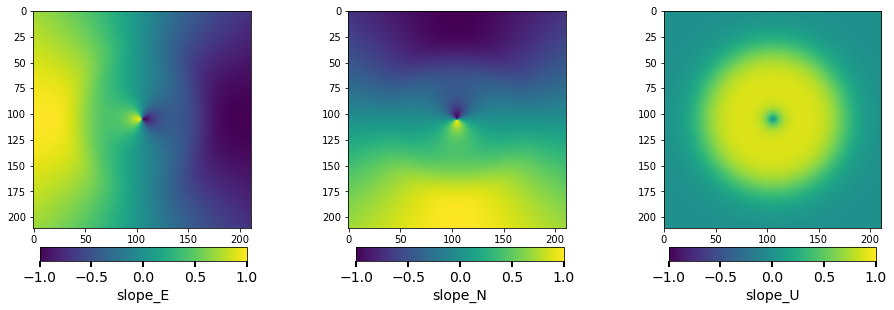

In [8]:
fig, ax = plt.subplots(1,3, figsize=(16,4))
im = ax[0].imshow(slope_E, cmap="viridis", vmin=-1, vmax=1)
cax = fig.add_axes([0.15, 0.01, 0.18, 0.05])
cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=-1, vmax=1)
cbar = mpl.colorbar.ColorbarBase(ax=cax, cmap=cmap, norm=norm, orientation='horizontal')
cbar.set_label('slope_E', size=14)
cbar.ax.tick_params(labelsize=14, width=2, length=6) 

im = ax[1].imshow(slope_N, cmap="viridis", vmin=-1, vmax=1)
cax = fig.add_axes([0.425, 0.01, 0.18, 0.05])
cbar = mpl.colorbar.ColorbarBase(ax=cax, cmap=cmap, norm=norm, orientation='horizontal')
cbar.set_label('slope_N', size=14)
cbar.ax.tick_params(labelsize=14, width=2, length=6) 

im = ax[2].imshow(slope_U, cmap="viridis", vmin=-1, vmax=1)
cax = fig.add_axes([0.696, 0.01, 0.18, 0.05])
cbar = mpl.colorbar.ColorbarBase(ax=cax, cmap=cmap, norm=norm, orientation='horizontal')
cbar.set_label('slope_U', size=14)
cbar.ax.tick_params(labelsize=14, width=2, length=6) 

These slope decomposition reflects slope vectors that point uphill

In [9]:
# fig, ax = plt.subplots(1,3, figsize=(16,4))
# im = ax[0].imshow(slope_E2, cmap="viridis", vmin=-1, vmax=1)
# cax = fig.add_axes([0.15, 0.01, 0.18, 0.05])
# cmap = mpl.cm.viridis
# norm = mpl.colors.Normalize(vmin=-1, vmax=1)
# cbar = mpl.colorbar.ColorbarBase(ax=cax, cmap=cmap, norm=norm, orientation='horizontal')
# cbar.set_label('slope_E2', size=14)
# cbar.ax.tick_params(labelsize=14, width=2, length=6) 

# im = ax[1].imshow(slope_N2, cmap="viridis", vmin=-1, vmax=1)
# cax = fig.add_axes([0.425, 0.01, 0.18, 0.05])
# cbar = mpl.colorbar.ColorbarBase(ax=cax, cmap=cmap, norm=norm, orientation='horizontal')
# cbar.set_label('slope_N2', size=14)
# cbar.ax.tick_params(labelsize=14, width=2, length=6) 

# im = ax[2].imshow(slope_U2, cmap="viridis", vmin=-1, vmax=1)
# cax = fig.add_axes([0.696, 0.01, 0.18, 0.05])
# cbar = mpl.colorbar.ColorbarBase(ax=cax, cmap=cmap, norm=norm, orientation='horizontal')
# cbar.set_label('slope_U2', size=14)
# cbar.ax.tick_params(labelsize=14, width=2, length=6) 

In [10]:
# define constant LOS vel
V_LOS = 20 #mm/year

#Calculate C
C = D_N*slope_N + D_E*slope_E + D_U*slope_U

V_slope = V_LOS/C

Text(0.5, 1.0, 'Slope angle combinations with C<0.3 \nmax v_slope = 170816.16291481524')

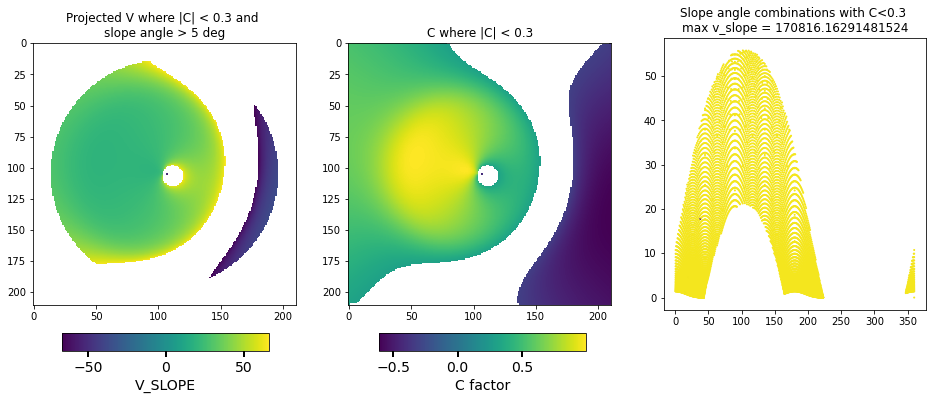

In [11]:
threshold = 0.3

C_mask = np.ma.masked_where((C > -threshold) & (C < threshold), C)
C_tr = np.ma.masked_where((abs(C) < threshold*0.99) | (abs(C) > threshold*1.18), np.ceil(abs(C)))
V_mask = np.ma.masked_where((C > -threshold) & (C < threshold) | (slope_DEM < 5), V_slope)


fig, ax = plt.subplots(1,3, figsize=(16,5))
im = ax[0].imshow(V_mask)
cax = fig.add_axes([0.15, 0.01, 0.18, 0.05])
cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=np.nanmin(V_mask), vmax=np.nanmax(V_mask))
cbar = mpl.colorbar.ColorbarBase(ax=cax, cmap=cmap, norm=norm, orientation='horizontal')
cbar.set_label('V_SLOPE', size=14)
cbar.ax.tick_params(labelsize=14, width=2, length=6) 
ax[0].set_title("Projected V where |C| < {} and \nslope angle > 5 deg".format(threshold))

ax[1].imshow(C_mask)
# ax[1].imshow(abs(C_tr), cmap="magma")
cax = fig.add_axes([0.425, 0.01, 0.18, 0.05])
norm = mpl.colors.Normalize(vmin=np.nanmin(C), vmax=np.nanmax(C))
ax[1].set_title("C where |C| < {}".format(threshold))

cbar = mpl.colorbar.ColorbarBase(ax=cax, cmap=cmap, norm=norm, orientation='horizontal')
cbar.set_label('C factor', size=14)
cbar.ax.tick_params(labelsize=14, width=2, length=6) 

im = ax[2].scatter(aspect_DEM[(C > -threshold) & (C < threshold)], 
                   slope_DEM[(C > -threshold) & (C < threshold)], 
                   s=1, c=V_slope[(C > -threshold) & (C < threshold)])
ax[2].set_title("Slope angle combinations with C<0.3 \nmax v_slope = {}".format(np.max(V_slope)))


The Velocity projection "skyrockets" on values very close to 0. Also 

In [12]:

# Project this vel and see where it fails

# plot the C factor and see its relation with aspect and slope

#check differences between slope decompositions